In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Preprocessed_Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Preprocessed_Dataset/Normal/Normal-671.png  
  inflating: Preprocessed_Dataset/Normal/Normal-6710.png  
  inflating: Preprocessed_Dataset/Normal/Normal-6711.png  
  inflating: Preprocessed_Dataset/Normal/Normal-6712.png  
  inflating: Preprocessed_Dataset/Normal/Normal-6713.png  
  inflating: Preprocessed_Dataset/Normal/Normal-6714.png  
  inflating: Preprocessed_Dataset/Normal/Normal-6715.png  
  inflating: Preprocessed_Dataset/Normal/Normal-6716.png  
  inflating: Preprocessed_Dataset/Normal/Normal-6717.png  
  inflating: Preprocessed_Dataset/Normal/Normal-6718.png  
  inflating: Preprocessed_Dataset/Normal/Normal-6719.png  
  inflating: Preprocessed_Dataset/Normal/Normal-672.png  
  inflating: Preprocessed_Dataset/Normal/Normal-6720.png  
  inflating: Preprocessed_Dataset/Normal/Normal-6721.png  
  inflating: Preprocessed_Dataset/Normal/Normal-6722.png  
  inflating: Preprocessed_Dataset/Normal/Normal-6723.png  
  infla

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [4]:
c = './Preprocessed_Dataset/COVID'
n = './Preprocessed_Dataset/Normal'
p = './Preprocessed_Dataset/Viral_pneumonia'
l = './Preprocessed_Dataset/Lung_Opacity'

In [5]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n),6000) + os.listdir(p) + os.listdir(l)

In [6]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(2))
    elif category == 'Viral Pneumonia':
        categories.append(str(1))
    elif category == 'Lung_Opacity':
        categories.append(str(3))
    else:
        categories.append(str(0))

In [7]:
print(len(categories))
unique, counts = np.unique(categories, return_counts=True)

result = np.column_stack((unique, counts)) 
print (result)

16973
[['0' '6000']
 ['1' '1345']
 ['2' '3616']
 ['3' '6012']]


In [8]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    elif 'Lung_Opacity' in filenames[i]:
        filenames[i] = os.path.join(l, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

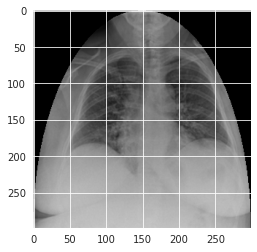

COVID


In [9]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()
a=sample.split('/')[-1]
b=a.split('-')[0]
print(b)

In [10]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [11]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [12]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 13578 validated image filenames belonging to 4 classes.


In [13]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 1698 validated image filenames belonging to 4 classes.


In [15]:
baseModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(4, activation='softmax')(headModel)

model1 = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

In [16]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [17]:
opt = Adam(learning_rate=0.0001)
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
epochs = 10
history = model1.fit_generator(train_generator, epochs=epochs,
                              validation_data=valid_generator, verbose=1)

Epoch 1/10
425/425 [==============================] - 256s 568ms/step - loss: 0.9738 - accuracy: 0.5879 - val_loss: 0.7912 - val_accuracy: 0.6802
Epoch 2/10
425/425 [==============================] - 240s 565ms/step - loss: 0.8206 - accuracy: 0.6634 - val_loss: 0.7235 - val_accuracy: 0.7150
Epoch 3/10
425/425 [==============================] - 241s 567ms/step - loss: 0.7560 - accuracy: 0.6891 - val_loss: 0.6704 - val_accuracy: 0.7367
Epoch 4/10
425/425 [==============================] - 241s 566ms/step - loss: 0.7203 - accuracy: 0.7088 - val_loss: 0.6644 - val_accuracy: 0.7356
Epoch 5/10
425/425 [==============================] - 238s 561ms/step - loss: 0.6964 - accuracy: 0.7198 - val_loss: 0.6362 - val_accuracy: 0.7426
Epoch 6/10
425/425 [==============================] - 242s 568ms/step - loss: 0.6773 - accuracy: 0.7286 - val_loss: 0.6317 - val_accuracy: 0.7367
Epoch 7/10
425/425 [==============================] - 246s 579ms/step - loss: 0.6650 - accuracy: 0.7350 - val_loss: 0.6149 -

In [ ]:
model1.save('model_with_preprocessed1.h5')

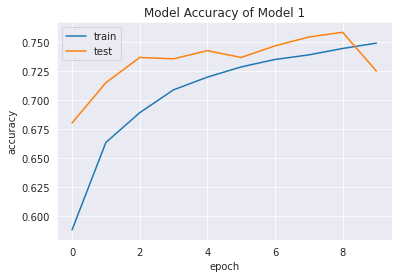

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy of Model 1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

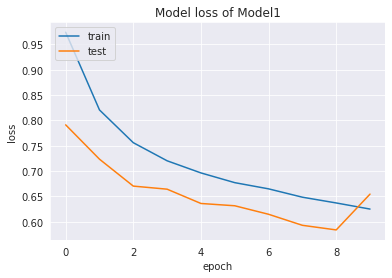

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss of Model1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model1.evaluate(test_generator)

54/54 [==============================] - 17s 310ms/step - loss: 0.5750 - accuracy: 0.7596


[0.5750433802604675, 0.7595757246017456]

In [21]:
sample = (test_data['filename'])

In [22]:
pred=[]
for i in sample:
  image = load_img(i, target_size=(224, 224))
  img = img_to_array(image)
  img=img/255.0
  img = img.reshape((1, 224, 224, 3))
  result = model1.predict(img)
  result = np.argmax(result, axis=-1)
  pred=np.hstack((pred,result))

In [23]:
actual=np.array(test_data['category'])
pred=pred.astype(int)

[[556  15 159 143]
 [  6  95   5   1]
 [  3   1 121   8]
 [ 35  24  76 449]]
              precision    recall  f1-score   support

           0       0.93      0.64      0.75       873
           1       0.70      0.89      0.79       107
           2       0.34      0.91      0.49       133
           3       0.75      0.77      0.76       584

    accuracy                           0.72      1697
   macro avg       0.68      0.80      0.70      1697
weighted avg       0.80      0.72      0.74      1697



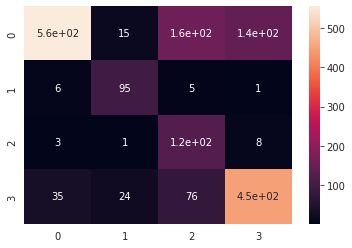

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(pred.astype(str),actual.astype(str)), annot=True)
print(confusion_matrix(pred.astype(str),actual.astype(str)))
print(classification_report(pred.astype(str),actual.astype(str)))

In [25]:
from tensorflow.keras.optimizers import SGD
model2 = Model(inputs=baseModel.input, outputs=headModel)
opt2 = SGD(learning_rate=0.0001)
model2.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
epochs = 10
history2 = model2.fit_generator(train_generator, epochs=epochs,
                              validation_data=valid_generator, verbose=1)

Epoch 1/10
425/425 [==============================] - 239s 559ms/step - loss: 0.6083 - accuracy: 0.7584 - val_loss: 0.5882 - val_accuracy: 0.7585
Epoch 2/10
425/425 [==============================] - 237s 558ms/step - loss: 0.6050 - accuracy: 0.7608 - val_loss: 0.5889 - val_accuracy: 0.7597
Epoch 3/10
425/425 [==============================] - 238s 561ms/step - loss: 0.6019 - accuracy: 0.7606 - val_loss: 0.5854 - val_accuracy: 0.7556
Epoch 4/10
425/425 [==============================] - 238s 560ms/step - loss: 0.6010 - accuracy: 0.7610 - val_loss: 0.5818 - val_accuracy: 0.7585
Epoch 5/10
425/425 [==============================] - 239s 562ms/step - loss: 0.5979 - accuracy: 0.7607 - val_loss: 0.5854 - val_accuracy: 0.7550
Epoch 6/10
425/425 [==============================] - 236s 555ms/step - loss: 0.6032 - accuracy: 0.7609 - val_loss: 0.5853 - val_accuracy: 0.7568
Epoch 7/10
425/425 [==============================] - 238s 560ms/step - loss: 0.5988 - accuracy: 0.7669 - val_loss: 0.5872 -

In [ ]:
model2.save('model_with_preprocessed2.h5')

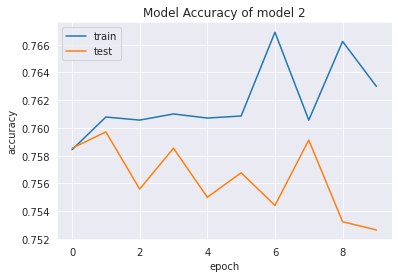

In [27]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy of model 2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

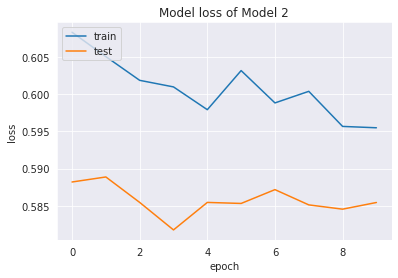

In [28]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss of Model 2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

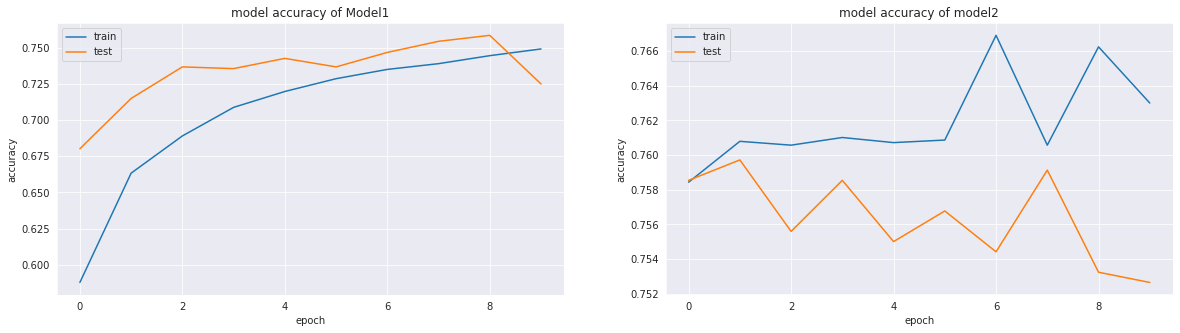

In [29]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of Model1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(122)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy of model2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

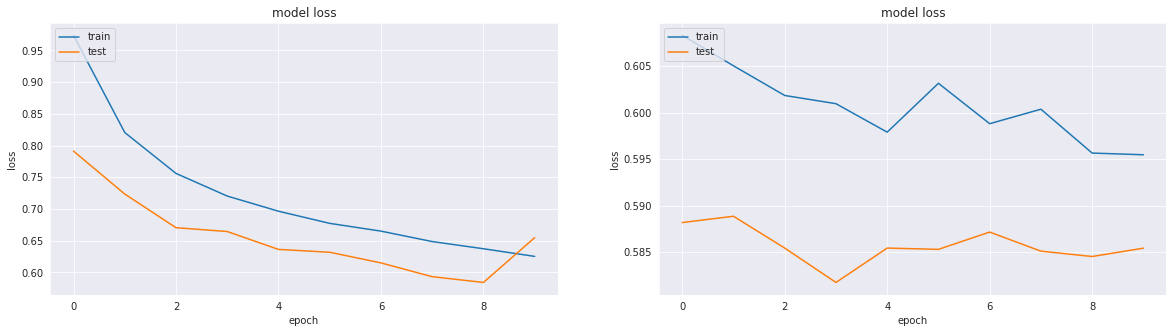

In [30]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(122)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
pred2=[]
for i in sample:
  image = load_img(i, target_size=(224, 224))
  img = img_to_array(image)
  img=img/255.0
  img = img.reshape((1, 224, 224, 3))
  result2 = model2.predict(img)
  result2 = np.argmax(result2, axis=-1)
  pred2=np.hstack((pred2,result2))

In [32]:
actual=np.array(test_data['category'])
pred2=pred2.astype(int)

[[529  14  99 101]
 [  7  94   6   1]
 [ 12   1 183  18]
 [ 52  26  73 481]]
              precision    recall  f1-score   support

           0       0.88      0.71      0.79       743
           1       0.70      0.87      0.77       108
           2       0.51      0.86      0.64       214
           3       0.80      0.76      0.78       632

    accuracy                           0.76      1697
   macro avg       0.72      0.80      0.74      1697
weighted avg       0.79      0.76      0.76      1697



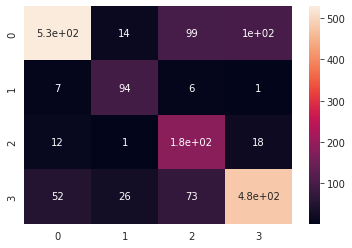

In [33]:
sns.heatmap(confusion_matrix(pred2.astype(str),actual.astype(str)), annot=True)
print(confusion_matrix(pred2.astype(str),actual.astype(str)))
print(classification_report(pred2.astype(str),actual.astype(str)))